<a href="https://colab.research.google.com/github/Kanishkar-git/DLT_LAB-Experiments/blob/master/dlt_exp11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 — D loss: 0.6026, G loss: 0.6902


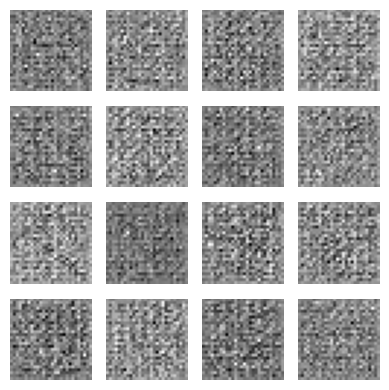

Epoch 200 — D loss: 0.8872, G loss: 0.4000


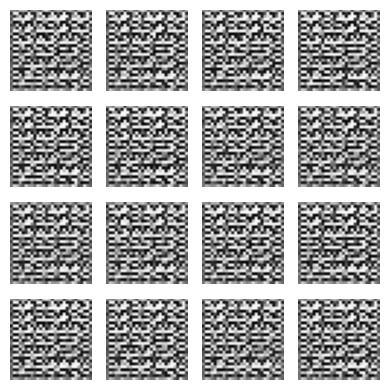

Epoch 400 — D loss: 1.1747, G loss: 0.2543


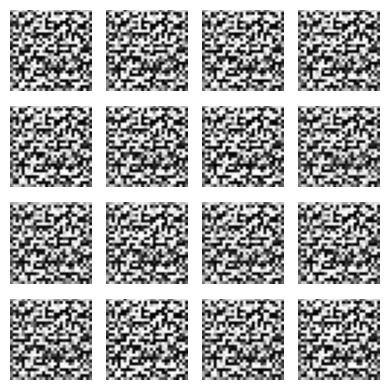

Epoch 600 — D loss: 1.3877, G loss: 0.1863


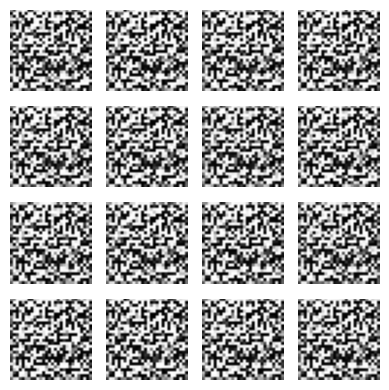

Epoch 800 — D loss: 1.5349, G loss: 0.1487


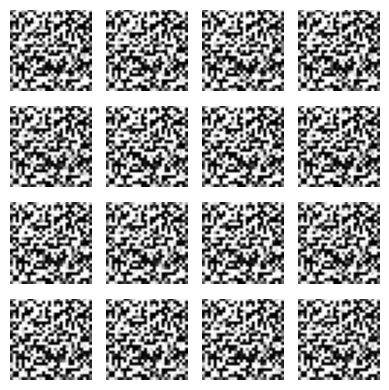

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Load and normalize MNIST data
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)

# Define Generator
def build_generator():
    model = Sequential([
        Dense(128 * 7 * 7, input_dim=100),
        LeakyReLU(0.2),
        Reshape((7, 7, 128)),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(0.2),
        Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='tanh')
    ])
    return model

# Define Discriminator
def build_discriminator():
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(28, 28, 1)),
        LeakyReLU(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

# Build and compile models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Combined GAN model
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(100,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')

# Visualize generated images
def show_images():
    noise = np.random.normal(0, 1, (16, 100))
    gen_imgs = generator.predict(noise, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(4, 4, figsize=(4, 4))
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.tight_layout()
    plt.show()

# Training function
def train_gan(epochs=1000, batch_size=128):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_imgs = x_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)

        # Display progress every 200 epochs
        if epoch % 200 == 0:
            print(f"Epoch {epoch} — D loss: {d_loss_real[0]:.4f}, G loss: {g_loss:.4f}")
            show_images()

# Run training
train_gan(epochs=1000, batch_size=128)
